<h1><center> Домашняя работа #3</center></h1>

Задача:

- еализуйте алгоритм А2С (Advanced Actor Critic)
- обучите агента в среде Car Racing;

Описание задачи на сайте Gymnasium ([ссылка](https://gymnasium.farama.org/environments/box2d/lunar_lander/))

## Imports

In [9]:
1 + 1

2

In [1]:
# !nvidia-smi

In [2]:
import sys

sys.path.append("..")

In [3]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from tqdm import trange
from torch import nn
from torch.nn import functional as F

# Commented since the code is commented too
# from stable_baselines3 import A2C
# from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import (
#     DummyVecEnv,
#     VecMonitor,
#     VecFrameStack,
#     VecTransposeImage,
# )

In [4]:
# %load_ext autoreload
# %autoreload 2

from src.torch_utils import get_device, preprocess_state, transform_state_to_tensor
from src.actor_critic import (
    ActorNet,
    ValueNet,
    compute_returns,
)

In [5]:
# %load_ext tensorboard

## Environment

**Observation space:**

A top-down 96x96 RGB image of the car and race track.

**Actions:**

- 0: steering, -1 is full left, +1 is full right
- 1: gas
- 2: braking

The three numbers (in order) are:

1. Steering
   - Range: [-1.0, 1.0]
   - Negative values: turn left
   - Positive values: turn right
2. Acceleration (Gas)
   -  Range: [0.0, 1.0]
   - 0 = no acceleration
   - 1 = full acceleration
3. Brake
    -  Range: [0.0, 1.0]
   - 0 = no braking
   - 1 = full braking

---

Example Actions:

- [0.0, 0.5, 0.0] → Go straight, accelerate at 50% power, no brake.
- [-0.8, 0.1, 0.0] → Sharp left turn, low acceleration.
- [0.3, 0.0, 0.7] → Gentle right turn, no gas, brake at 70%.

**Rewards:**

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

In [6]:
# %pip install swig

In [7]:
# %pip install Box2D

---
## Версия в stable_baselines3

Мы используем CnnPolicy, так как нам нужна сверточная нейросеть для обработки изображения

Обучение идет, но нужно очень много шагов. Нормально не работает. -> Код закоментирован

In [8]:
# env = make_vec_env(
#     env_id="CarRacing-v3",
#     n_envs=4,
#     env_kwargs={"continuous": True, 'max_episode_steps': 1_000},
#     vec_env_cls=DummyVecEnv
# )

In [9]:
# env = VecMonitor(env)
# env = VecFrameStack(env, n_stack=4)
# env = VecTransposeImage(env)

In [10]:
# model = A2C(
#     policy="CnnPolicy",
#     n_steps=512,
#     gamma=0.99,
#     learning_rate=3e-4,
#     max_grad_norm=0.5,
#     use_rms_prop=True,
#     vf_coef=0.25,
#     ent_coef=0.01,
#     gae_lambda=0.95,
#     normalize_advantage=True,
#     tensorboard_log=None,
#     env=env,
#     verbose=1
# )

In [11]:
# model.learn(
#     total_timesteps=250_000,
#     progress_bar=True
# )

In [12]:
# %tensorboard --logdir ./a2c_carracing_tensorboard/

In [13]:
# model.save("car_racing_baseline")

In [14]:
# model = A2C.load("car_racing_baseline")

In [15]:
# def create_agent_env():
#     def _init():
#         env = gym.make(
#             "CarRacing-v3",
#             continuous=True,
#             domain_randomize=False,
#             lap_complete_percent=0.95,
#             max_episode_steps=5_000,
#             render_mode="rgb_array",
#         )
#         return env
#     env = DummyVecEnv([_init])
#     env = VecFrameStack(env, n_stack=4)
#     env = VecTransposeImage(env)
#     return env

In [16]:
# agent_env = create_agent_env()
# render_env = gym.make(
#     "CarRacing-v3",
#     continuous=True,
#     domain_randomize=False,
#     lap_complete_percent=0.95,
#     max_episode_steps=5_000,
#     render_mode="human",
# )

In [17]:
# obs_agent = agent_env.reset()
# obs_render, _ = render_env.reset()

# done = False
# score = 0

# while not done:
#     action, _ = model.predict(obs_agent, deterministic=True)
#     obs_agent, reward, done, _ = agent_env.step(action)
#     _, _, _,_, _ = render_env.step(action[0])
#     score += reward[0]

In [18]:
# agent_env.close()
# render_env.close()

---
## Свой класс

## Реализация:
1. Инициализируем случайным образом сети политики (actor) $\pi^{\mu}(a|s)|_{\theta^{\mu}}$ и V-функции (critic) $V^{\theta}(s)|_{\theta^{V}}$ с весами $\theta^V$ и $\theta^{\mu}$ и целевые сети $V'$ и $\pi'$: $\theta^{V'} \gets \theta^V$ и $\theta^{\mu'} \gets \theta^{\mu}$
2. Устанавливаем число эпизодов обучения $M$ и для каждого эпизода выполняем:
3. Проходим траекторию, пока не достигнем конечного состояния.
    - Находясь в состоянии $s_t$ действуем в силу текущей политики и выбираем действие $a_t = \pi^{\mu}(s_t)|_{\theta^{\mu}}$
    - Выполняем действие $a_t$ и переходим в состояние $s_{t+1}$ и получаем награду $r_t$
    - В состоянии $s_{t+1}$ действуя в силу текущей политики выбираем действие $a_{t+1} = \pi^{\mu}(s_{t+1})|_{\theta^{\mu}}$
    - Вычисляем $Loss(\theta^V)=\big( r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t) \big)^2$
    - Вычисляем $Loss(\theta^{\mu}) = \ln{\pi^{\mu}(a_t|s_t)}(r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t))$
    - Обновляем веса: </br>
    __Внимание!__ У V-функции мы ___минимизируем___ веса, а в политике ___максимизируем_!__ </br>
      $\quad \quad \theta^V \gets \theta^V - \alpha \nabla_{\theta^V}Loss(\theta^V)$, </br>
      $\quad \quad \theta^{\mu} \gets \theta^{\mu} + \beta \nabla_{\theta^{\mu}}Loss(\theta^{\mu})$
    - Обновляем целевые сети: </br>
    $\quad \quad \theta^{V'} \gets \tau \theta^V + (1 - \tau) \theta^{V'}$, </br>
    $\quad \quad \theta^{\mu'} \gets \tau \theta^{\mu} + (1 - \tau) \theta^{\mu'}$

In [8]:
env = gym.make(
    "CarRacing-v3",
    continuous=True,
    domain_randomize=False,
    lap_complete_percent=0.95,
    max_episode_steps=1_000,
    # render_mode="human",  # Раскомментируйте, чтобы увидеть игру
)

C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Чтобы использовать сразу несколько изображений

In [10]:
env = gym.wrappers.FrameStackObservation(env, 4)

In [11]:
# Пример state
print(env.observation_space)

Box(0, 255, (4, 96, 96, 3), uint8)


In [12]:
# Пример action
print(env.action_space.sample())

[0.26906255 0.08858459 0.16914071]


In [13]:
device = get_device()

Используемое устройство: cpu


In [14]:
# Основные параметры RL
gamma = torch.tensor(0.99).to(device)  # discount_factor
num_episodes = 2  # 250

# Основные параметры DL
lr = 1e-3
max_grad_norm = 0.5

In [15]:
actor_model = ActorNet().to(device)
value_model = ValueNet().to(device)

In [16]:
# state = transform_state_to_tensor(state)

In [17]:
# actor_model.get_action_and_log_prob(state)

In [18]:
opt_actor = torch.optim.AdamW(actor_model.parameters(), lr=lr, fused=True)
opt_value = torch.optim.AdamW(value_model.parameters(), lr=lr, fused=True)

In [19]:
reward_records = []

for episode in trange(num_episodes):

    done = False
    visited_states = []
    terminated_flags = []
    actions = []
    rewards = []
    state, _ = env.reset()

    # Play one episode (collect trajectory)
    while not done:

        state = preprocess_state(state)
        state = transform_state_to_tensor(state, device=device)
        visited_states.append(state.squeeze(0))

        with torch.no_grad():
            raw_actions, transformed_actions = actor_model.get_actions(state)

        state, reward, terminated, truncated, _ = env.step(
            transformed_actions.cpu().numpy().flatten()
        )

        done = terminated or truncated
        terminated_flags.append(done)
        actions.append(raw_actions)
        rewards.append(reward)

    # Prepare data
    rewards_tensor = torch.tensor(rewards, device=device)

    # Train value model
    opt_value.zero_grad()

    values = value_model(torch.stack(visited_states))
    values = values.squeeze()

    returns = compute_returns(
        rewards=rewards_tensor, values=values, gamma=gamma, device=device
    )
    advantages = (returns - values).detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    value_model_loss = F.mse_loss(values, returns)
    value_model_loss.backward()

    nn.utils.clip_grad_norm_(value_model.parameters(), max_grad_norm)
    opt_value.step()

    # Train actor model
    opt_actor.zero_grad()

    log_probs_tensor = actor_model.get_log_prob_given_actions(
        state=torch.stack(visited_states), raw_actions=torch.cat(actions)
    )
    # log_probs_tensor = torch.cat(log_probs)

    policy_loss = -log_probs_tensor * advantages
    policy_loss.sum().backward()

    nn.utils.clip_grad_norm_(actor_model.parameters(), max_grad_norm)
    opt_actor.step()

    reward_records.append(sum(rewards))

    if episode % 5 == 0:
        print(f"Mean for last 5 episodes is {np.mean(reward_records[-5:])}")
        print(f"Mean for last 50 episodes is {np.mean(reward_records[-50:])}")

    # Stop if mean reward for 100 episodes > 475.0
    # Naive early stopping
    if np.average(reward_records[-100:]) > 475.0:
        break

print(f"\nDone in {episode+1} episodes")
env.close()

 50%|██████████████████████████████████████████                                          | 1/2 [01:04<01:04, 64.45s/it]

Mean for last 5 episodes is -1.1857707509879647
Mean for last 50 episodes is -1.1857707509879647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:09<00:00, 64.54s/it]


Done in 2 episodes


## Training graphs

In [21]:
table = pd.DataFrame(reward_records, columns=["reward"])
# table = table.iloc[2_000:, :]  # remove exploratory_period

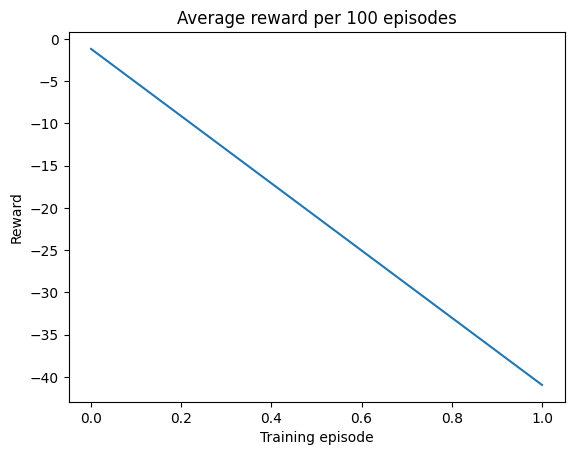

In [23]:
plt.plot(table.index, table["reward"])
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 100 episodes")
plt.show()

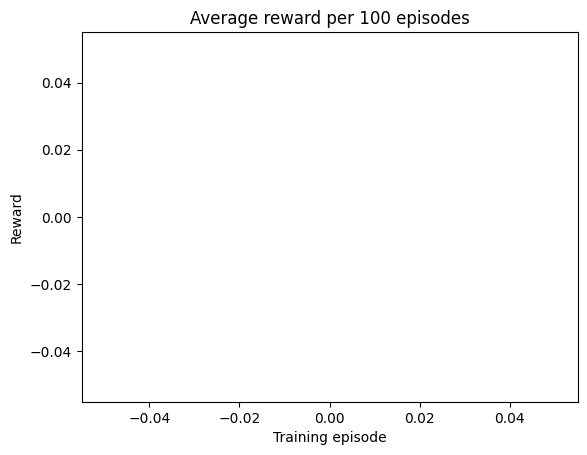

In [24]:
plt.plot(table.index, table["reward"].rolling(100).mean())
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 100 episodes")
plt.show()

## Анимация

In [25]:
env = gym.make(
    "CarRacing-v3",
    continuous=True,
    domain_randomize=False,
    lap_complete_percent=0.95,
    max_episode_steps=5_000,
    render_mode="human",  # Раскомментируйте, чтобы увидеть игру
)

In [26]:
env = gym.wrappers.FrameStackObservation(env, 4)

In [29]:
device = get_device()

done = False
state, _ = env.reset()

while not done:
    env.render()
    state = preprocess_state(state)
    state = transform_state_to_tensor(state, device=device)
    with torch.no_grad():
            _, transformed_actions = actor_model.get_actions(state)

    state, reward, terminated, truncated, _ = env.step(
        transformed_actions.cpu().numpy().flatten()
    )

    done = terminated or truncated

env.close()

print(f"Score is: {score}")

Используемое устройство: cpu


KeyboardInterrupt: 

In [30]:
env.close()